In [1]:
import os
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import typing
from scipy.stats import rankdata, median_abs_deviation
from scipy.signal import fftconvolve 

sns.set_theme(rc={'figure.figsize':(18,6)}, style="white")
os.chdir('/Users/zagidull/Documents/gerosense/presymptomatic_covid_detection_algo/')

In [2]:
# get data from https://storage.googleapis.com/gbsc-gcp-project-ipop_public/COVID-19/COVID-19-Wearables.zip
# RHR offline and CUSUM online on https://github.com/mwgrassgreen/WearableDetection
# HROS on https://github.com/gireeshkbogu/AnomalyDetect

### func defs

In [3]:
def readDF(patient_name: str, mypath: str='/Users/zagidull/Documents/gerosense/presymptomatic_covid_detection_algo/data_covidwearables/') -> pd.DataFrame:
    filename_hr = mypath+patient_name+'_hr.csv'
    filename_step = mypath+patient_name+'_steps.csv'

    df_hr = pd.read_csv(filename_hr, sep=',', header=0, index_col='datetime', parse_dates=True, usecols=['datetime', 'heartrate']) # would be good to set a format here format='%Y-%m-%d %H:%M:%S'
    df_step = pd.read_csv(filename_step, sep=',', header=0, index_col='datetime', parse_dates=True, usecols=['datetime', 'steps'])

    df_hr = df_hr.resample(rule='1T')[['heartrate']].mean() # change to 1min resolution to match with step counts

    df = pd.merge(df_hr, df_step, left_index=True, right_index=True)
    return df
               

In [4]:
def prepBaseline(df_input: pd.DataFrame, num_days: int=28) -> pd.DataFrame:
    # , start: int=None, end: int=None
    start = df_input.index[0]
    end = start + pd.Timedelta(seconds=num_days*24*60*60-1)
    df = df_input[start:end].copy()
    
    return df


In [5]:
def prepTest(df_input: pd.DataFrame, date: datetime.date, rolling_interval: int=10, robust=False) -> pd.DataFrame:
    
    df = df_input[ df_input.index.date == date].copy()
    df = smoothRolling(df, rolling_interval=rolling_interval, robust=robust)
    
    return df

In [6]:
def plotRHR(patient_name: str, save: bool=False, path: str=None):
    df = readDF(patient_name)
    df = prepBaseline(df)
    df = smoothRolling(df)
    df = getRHR(df)

    fig_object = plt.figure()
    ax = fig_object.add_subplot(1,1,1)
    ax.set_xlabel('Hour')
    ax.set_ylabel('RHR')
    ax.set_xticks(df.index)
    ax.set_title(f'average hourly RHR with CI95 over 28 days for {patient_name}')
    ax.plot(df.index, df['RHR_mean'], color='darkred')
    ax.plot(df.index, df['CI95_lower'], color='lightgrey')
    ax.plot(df.index, df['CI95_upper'], color='lightgrey')

    ax.fill_between(range(len(df.index)), df['CI95_upper'], df['CI95_lower'], color='lightgrey')
    if save and type(path) == str:
        fig_object.savefig(path+f'/{patient_name}_averageRHR.png')
        plt.close(fig_object)
    else:
        return fig_object

In [7]:
def plotAlerts(patient_name: str, l_cusums: list, df_rhrs: pd.DataFrame, ar_zvals: pd.Series, ar_cutoff: pd.Series, save: bool=False, path: str=None ):

    fig_object = plt.figure()
    ax = fig_object.add_subplot(1,1,1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Z-score')
    ax.set_title(f'RHR and CUSUM alerts for {patient_name}')
    
    ax.plot(ar_zvals)
    ax.plot(ar_cutoff, label='z-threshold', linewidth=2, color='darkgreen')
    ax.axhline(0, linewidth=2, color='blue')
    lower = np.ceil(np.min(ar_zvals))

    for i,row in df_rhrs.iterrows():
        ax.fill_betweenx(np.arange(lower,4,0.01), row[0], row[1], facecolor='red', alpha=0.2, label=f'RHR alert {i}')

    for cusum,i in zip(l_cusums, range(len(l_cusums))):
        ax.axvline(cusum, linewidth=4, color='darkred', label=f'cusum alert {i}')

    ax.legend()
    if save and type(path) == str:
        fig_object.savefig(path+f'/{patient_name}_alerts.png')
        plt.close(fig_object)
    else:
        return fig_object

In [8]:
def plotCusumProfile(patient_name: str, ar_cusums: np.ndarray, ar_cusums_baseline: np.ndarray,save: bool=False, path: str=None):
    fig_object = plt.figure()
    ax = fig_object.add_subplot(1,1,1)
    ax.plot(ar_cusums, label='all')
    ax.plot(ar_cusums_baseline, label='first 28 days')
    
    ax.set_title(f'CUSUM for {patient_name}')
    ax.set_xlabel('hour')
    ax.set_ylabel('CUSUM')
    
    ax.legend()
    if save and type(path) == str:
        fig_object.savefig(path+f'/{patient_name}_cusumprofile.png')
        plt.close(fig_object)
    else:
        return fig_object

In [9]:
def plotCusumRisks(patient_name: str, ar_risks: np.ndarray, ar_risks_baseline: np.ndarray, save: bool=False, path: str=None):
    fig_object = plt.figure()
    ax = fig_object.add_subplot(1,1,1)
    ax.plot(ar_risks, label='all')
    ax.plot(ar_risks_baseline, label='first 28 days')
    
    ax.set_title(f'CUSUM risk scores for {patient_name}')
    ax.set_xlabel('hour')
    ax.set_ylabel('Risk')
    
    ax.legend()
    if save and type(path) == str:
        fig_object.savefig(path+f'/{patient_name}_cusumrisks.png')
        plt.close(fig_object)
    else:
        return fig_object

In [10]:
def smoothRolling(df_input: pd.DataFrame, rolling_interval: int=10, robust=False) -> pd.DataFrame:
    df=df_input.copy()
     # smoothing using rolling_interval
    df['steps'] = df.groupby(df.index.day, as_index=False, sort=False)['steps']\
    .rolling(rolling_interval).sum()['steps'].values

    if robust:
        df['heartrate'] = df.groupby(df.index.day, as_index=False, sort=False)['heartrate']\
        .rolling(rolling_interval).median()['heartrate'].values
    else:
        df['heartrate'] = df.groupby(df.index.day, as_index=False, sort=False)['heartrate']\
        .rolling(rolling_interval).mean()['heartrate'].values

    return df

In [11]:
def getZscore(df_input: pd.DataFrame, df_refRHR: pd.DataFrame, z_cut: float=4.0) -> pd.DataFrame:
    '''
    downsamples heartrate from minutes to hourly using mean
    calculates z-score using provided hourly reference from previous 28 days
    hard-cuts z-score at +/- 4
    ToDo refactor, as now it throws away all, but heartrate, columns and does not follow the logic of other functions wrt input/output
    '''
    def norm_zscore(ar_zscore: np.ndarray, z_cut=z_cut) -> np.ndarray:
        return np.clip(ar_zscore, a_min=-z_cut, a_max=z_cut)
    
    df = df_input['heartrate'].resample('60T').mean().to_frame()
    df['zscore'] = norm_zscore(df.apply(
    lambda x: (x.values-df_refRHR.loc[x.index.hour,'RHR_mean'].values)/df_refRHR.loc[x.index.hour,'RHR_std'].values 
).values)
    df.zscore.fillna(0, inplace=True)
    
    return df

In [12]:
def getRHR(df_input: pd.DataFrame) -> pd.DataFrame:
    '''
    use normal stats to get RHR
    '''
    temp = df_input[df_input.steps==0].copy()
    grouper = temp['heartrate'].groupby(temp.index.hour)
    
    rhr_mean = grouper.agg(lambda x: np.nanmean(x))
    rhr_std = grouper.agg(lambda x: np.nanstd(x) )
    
    df_RHR = pd.concat([rhr_mean,rhr_std], axis=1)
    df_RHR.columns = ['RHR_mean', 'RHR_std']
    df_RHR.index.names = ['hour']

    return df_RHR 

In [13]:
def getRHR_robust(df_input: pd.DataFrame) -> pd.DataFrame:
    '''
    use robust stats for RHR
    '''
    temp = df_input[df_input.steps==0].copy()
    grouper = temp['heartrate'].groupby(temp.index.hour)
    
    rhr_median = grouper.agg(lambda x: np.nanmedian(x))
    rhr_mad = grouper.agg(lambda x: median_abs_deviation(x, nan_policy='omit') ) * 1.4826 #use scale normal to get to the same scale as normal z-scores
    
    df_RHR = pd.concat([rhr_median,rhr_mad], axis=1)
    df_RHR.columns = ['RHR_median', 'RHR_mad']
    df_RHR.index.names = ['hour']

    return df_RHR 

In [14]:
def getZscore_robust(df_input: pd.DataFrame, df_refRHR: pd.DataFrame, z_cut: float=4.0) -> pd.DataFrame:
    '''
    downsamples heartrate from minutes to hourly using median
    calculates robust z-score using provided hourly reference from previous 28 days with robust statistics
    hard-cuts it at +/- 4
    z = (val - median)/median_abs_deviation
    '''
    def norm_zscore(ar_zscore: np.ndarray, z_cut=z_cut) -> np.ndarray:
        return np.clip(ar_zscore, a_min=-z_cut, a_max=z_cut)
    
    df = df_input['heartrate'].resample('60T').median().to_frame()
    df['zscore'] = norm_zscore(df.apply(
        lambda x: (x.values-df_refRHR.loc[x.index.hour,'RHR_median'])/ df_refRHR.loc[x.index.hour,'RHR_mad'].values ).values)
    df.zscore.fillna(0, inplace=True)
    
    return df

In [15]:
def getResidualThreshold(ar_zscore, q=0.90, method='linear'):
    return np.nanquantile(ar_zscore, q=q, method=method)/2

In [16]:
def getCusumBase(ar_zscore: np.ndarray, z_threshold: float) -> np.ndarray:
    '''
    calculate cusums scores for z-scores of the reference period 
    '''
    ar = np.copy(ar_zscore)
    ar[np.isnan(ar)]=0
    #ar=ar_zscore
    a = np.zeros_like(ar)
    for i in range(len(a)):
        if i==0:
            a[0] = np.maximum(0, ar[i]-z_threshold)
        else:
            a[i] = np.maximum(0, a[i-1]+ar[i-1]-z_threshold)
        
    return a

In [17]:
def getCusumTest(ar_zscore_test: np.ndarray, ar_cusum_ref: np.ndarray, z_threshold: float) -> np.ndarray:
    '''
    calculate cusums scores for z-scores of the test period 
    '''
    ar = np.copy(ar_zscore_test)
    ar[np.isnan(ar)]=0
    #ar = ar_zscore_test
    a = np.zeros_like(ar)
    for i in range(len(a)):
        if i==0:
            a[i]=ar_cusum_ref[-1]
        else:
            a[i]=np.maximum(0, a[i-1]+ar[i-1]-z_threshold)
    return a

In [18]:
def getECDF(ar_cusum_input: np.ndarray) -> dict:
    '''
    calculate ECDFs of cusum vals, used to assign risk scores later
    * im not sure if counting until the start of the next period is valid for creating intervals of CUSUM values, but what's they do in the Mishra et al 2020. 
    getECDf_alt calculates interval lengths as between start and end  
    '''
    a = ar_cusum_input
    ar = np.concatenate( ([0], np.not_equal(a, 0).astype(int)) ) # 
    ar_eq = np.ediff1d(ar) # run difference between consecutive values
    ind0 = np.argwhere(ar_eq==1).reshape(-1) # begin of array is 1, first idx after end is -1
    if len(ind0)>1:
        ar_diff = np.diff(ind0, n=1) # diff between first idx values
    else:
        ar_diff = a.shape[0] - ind0[0]
    steps = list(range(1, np.max(ar_diff)+1)) # our interval lengths
    
    d = dict()
    for step in steps:
        l = []
        for start_idx in ind0:
            stop_idx=start_idx+step
            if stop_idx >= len(a):
                stop_idx = a.shape[0]#-1
            m = max(a[start_idx:stop_idx])
            l.append(m)
        d[step] = ECDF(l)
    return d

In [19]:
def getECDF_alt(ar_cusum_input: np.ndarray) -> dict:
    a = ar_cusumREF
    ar = np.concatenate( ([0], np.not_equal(a, 0).astype(int)) ) # 
    ar_eq = np.ediff1d(ar) # run difference between consecutive values
    ind0 = np.argwhere(ar_eq==1).reshape(-1) # begin of array is 1, first idx after end is -1
    ind1 = np.argwhere(ar_eq==-1).reshape(-1)
    if ind0.shape[0] > ind1.shape[0]:
        ind1=np.concatenate( ( ind1, [a.shape[0] ]))
    
    max_step = max(ind1-ind0) + 1
    
    d = dict()
    for step in range(1, max_step):
        l = []
        for start_idx in ind0:
            stop_idx=start_idx+step
            if stop_idx >= len(a):
                stop_idx = a.shape[0]
            m = max(a[start_idx:stop_idx])
            l.append(m)
        d[step] = ECDF(l)
    return d
    

In [20]:
def getRiskScores(ar_cusum_input: np.ndarray, ar_cusum_idx_input: np.ndarray, d_ecdf_input: dict) -> np.ndarray:
    '''
    risk score from (0 to 1) based on cusum stat 
    defined as a percentile of the CUSUM stat based on precalculated ECDF
    important to know (continuous) interval of CUSUM values != 0, as ECDF changes (grows) for longer intervals
    AND 
    risk is set as 1 if a continuous CUSUM interval is longer, than the longest found in reference period
    '''
    risk_scores = np.zeros_like(ar_cusum_input) # reference period
    
    for val,idx in zip(ar_cusum_idx_input, range(ar_cusum_idx_input.shape[0])):
        if val >= 1 and val in d_ecdf_input.keys():
            risk_scores[idx] = d_ecdf_input.get(val)(ar_cusum_input[idx]) # they subtract 0.001 from quantiles idk why tbh
        if val > max(d_ecdf_input.keys()):
            risk_scores[idx] =1

    return risk_scores

In [21]:
def getCusumIdx(ar_cusum_input: np.ndarray) -> np.ndarray :
    '''
    get indices of non-zero CUSUM stats
    reset idx if previous cusum is equal to zero
    '''
    a = np.zeros(ar_cusum_input.shape, dtype=int)
    if ar_cusum_input[0]==0:
        a[0]=0
    else:
        a[0]=1
    for val,i in zip(ar_cusum_input[1:], range(1, len(ar_cusum_input))):
        if val>0:
            a[i]=a[i-1]+1
    return a
            

In [22]:
def updateCusumIdx(ar_cusum_input_test: np.ndarray, ar_cusum_idx_ref: np.ndarray) -> np.ndarray :
    ''' 
    here we need an array of refence cusum stats
    which are then used to calculate index of non-zero cusum values in the test period
    '''
    a = np.zeros(ar_cusum_input_test.shape, dtype=int)
    if ar_cusum_input_test[0]==0:
        a[0]=0
    else: a[0]= ar_cusum_idx_ref[-1]+1
    for val,i in zip(ar_cusum_input_test[1:], range(1, len(ar_cusum_input_test))):
        if val>0:
            a[i]=a[i-1]+1
    return a

In [23]:
def getMaxAtk(ar_rank_n: np.ndarray, k: int) -> float:
    '''
    get max possible rank statistic for an array via fftconvolve. STILL NOT SURE HOW EXACTLY IT WORKS!
    '''
    n = len(ar_rank_n)
    meanrank = (n+1)/2
    Intv = [1]*k + [0]*(n-k) #?????
    return np.max(fftconvolve(ar_rank_n-meanrank, Intv, mode='same')[:n-k+1])/np.sqrt(k)

In [24]:
def getRankScan(ar_rank_null: np.ndarray, len_interval: int) -> float:
    '''
    get max possible rank for a given interval length
    '''
    #len_interval = int(len_interval)
    #n = len(ar_rank_null)
    max_at_k = np.empty(len_interval, dtype=float)
    max_at_k[0] = float(len_interval) #
    for i in range(1, len_interval):
        max_at_k[i] = getMaxAtk(ar_rank_null, 2**i)
    return np.max(max_at_k)

In [25]:
def getCriticalRankNull(len_z_array: int, interval_limit: int, alpha: float, permutation_count: int, seed: int=2) -> float:
    '''
    get null distribution of ranks for an array of z-score values of len=len_z_array, using intervals from 1 to interval limit and significance level alpha
    this is similar to getting a u-statistic for mann-whitney
    '''
    rng = np.random.default_rng(seed=seed)
    a = np.empty(permutation_count)
    for b in range(permutation_count):
        rank_null = rng.choice(np.arange(1,len_z_array+1,1), len_z_array, replace=False)
        a[b] = getRankScan(rank_null, interval_limit)
    return np.quantile(a, q=1-alpha)

In [26]:
def scanRanks(z_array_rank: np.ndarray, interval_limit: int, threshold_null: float) -> pd.DataFrame:
    '''
    magic that doesnt work
    '''
    b = len(z_array_rank)
    x = np.zeros(b*(2**interval_limit+1))
    for i in range(b-1):
        js=np.minimum(b, i+2**(np.arange(1,11)))
        for j in js:
            x[i*2**interval_limit+j-1]=np.sum(z_array_rank[i:j]-(b+1)*0.5)/np.sqrt(j-i+1)
    k=np.where(abs(x)>threshold_null)[0]
    #k=np.where(x>threshold_null)[0] # detect only positive rank scan values
    i=np.ceil(k/(2**interval_limit+1)).astype(int)
    j=k-(i-1)*2**interval_limit

    # thats just ew, essentially we wanna find non-overlapping period where CUSUM is above threshold
    ll = pd.DataFrame([i,j,abs(x[k])]).T # abs all rankscan values
    start=[]
    end=[]
    rankscans=[]
    while ll.shape[0] > 0:
        #idx = np.argmax(abs(ll.iloc[:,2]))
        idx = np.argmax(ll.iloc[:,2])
        rankscans.append(ll.iloc[idx,2])
        start.append(ll.iloc[idx,0])
        end.append(ll.iloc[idx,1])
        ll = ll.loc[~np.logical_and(ll[0]<=end[-1], ll[1]>=start[-1])]

    df_out = pd.DataFrame([start,end,rankscans], ).T
    df_out.columns = ['begin detect period', 'end detect period', 'rankscan statistic']
    
    return df_out



In [27]:
def getRHRalerts(array_zvals: np.ndarray, alpha: float = 0.05, permutation_count: int = 1000, seed: int = 435) -> pd.DataFrame:
    '''
    takes in array of z-scores, significane level, num permutations to calculates which z-scores are outliers
    this is down using rank scan test, which is a version of mann-whitney test for timeseries, so data->ranks, ranks sums in a given interval are compared with the threshold.
    threshold is calculated by a permutation test 
    '''
    if array_zvals.isna().any():
        array_zvals = array_zvals.fillna(0) # they fill in with zeroes in paper, maybe better to impute instead via linear interpolation or something?
    N = array_zvals.shape[0] 
    Q = np.floor(np.log2(N)).astype(int) # scan interval length
    d = getCriticalRankNull(len_z_array=N, interval_limit=Q, alpha=alpha, permutation_count=permutation_count, seed=seed) # null B can be used to calculate the pval but whatever i m not doing it
    
    # get rankscan stat for real z-scores
    z_vals_rank = rankdata(array_zvals) # scipy function care that nan policy is specified or array has no nans
    results = scanRanks(z_array_rank=z_vals_rank, interval_limit=Q, threshold_null=d)

    # rename columns to normal dates 
    results.loc[:,'begin detect period'] = array_zvals[results['begin detect period'].astype(int)].index 
    results.loc[:,'end detect period'] = array_zvals[results['end detect period'].astype(int)].index 
    
    # clean up detected intervals shorter than 24 hours
    to_pick = results['end detect period'] - results['begin detect period'] > pd.Timedelta('1day')
    results = results.loc[to_pick]

    # merge intervals that have gaps <48 hours into single RHR alert periods
    results = results.iloc[np.argsort(results['begin detect period'])] # sort by start date 
    to_pick = (results['begin detect period'].values[1:] - results['end detect period'].values[:-1]) > pd.Timedelta('2day')
    to_pick_begin = to_pick.tolist()
    to_pick_begin.insert(0, True) # always get firs time date
    to_pick_end = to_pick.tolist()
    to_pick_end.append(True) # always get last end date

    out = pd.DataFrame([results.loc[to_pick_begin, 'begin detect period'].values, results.loc[to_pick_end, 'end detect period'].values]).T
    out.columns = results.columns[:2]

    #results = abs(results)
    #results.reset_index(drop=True, inplace=True)
    return out
    

In [28]:
def ranges(nums):
    '''
    https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    alternative to r's rle
    '''
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

In [29]:
def getCusumAlerts(array_cusum, array_cusum_idx, array_risk_scores, array_zvals, threshold=0.99, min_duration=48):
    '''
    make it into cusum alert if CUSUM is larger than threshold for period longer than min_duration
    '''
    df_cusum_online = pd.DataFrame([array_cusum, array_cusum_idx, array_risk_scores]).T
    df_cusum_online.columns = ['cusum stat', 'cusum runindex', 'risk scores']
    rg = pd.DataFrame(ranges(df_cusum_online[df_cusum_online['cusum runindex'] > 0].index))
    rg['new'] = rg[1]-rg[0] >= min_duration
    rg = rg[rg.new == True]
    idx=[]
    for _,row in rg.iterrows():
        start=row[0]
        end=row[1]
        temp = df_cusum_online.iloc[start:end]['risk scores']
        if (temp>threshold).sum() > 0:
            idx.append((array_zvals.index[start]))
    return idx

In [30]:
def getRHRandCUSUMdata(patient_name: str, pval=0.01, robust=False):
    ##########
    #BASELINE get reference dataset from the first 28 days of measurements
    ##########
    
    df = readDF(patient_name)
    df_ref = prepBaseline(df) 
    #df_ref.dropna(inplace=True) # how to better deal with NAs? for now i manage them when calculating z-scores/residuals by filling with zero
    if robust:
        df_ref = smoothRolling(df_ref, robust=robust)
        df_RHR = getRHR_robust(df_ref)
        df_hourly = getZscore_robust(df_ref, df_RHR) # calculate z-scoresfor anomaly detection 
    else:
        df_ref = smoothRolling(df_ref)
        df_RHR = getRHR(df_ref) # get RHR based on reference from first 28 days
        df_hourly = getZscore(df_ref, df_RHR) # calculate z-scoresfor anomaly detection 
    
    zthreshold = getResidualThreshold(df_hourly.zscore) # use ref data to get z-threshold , after downsampling to hourly (from minutes
    
    # to store results for later plotting and alerts
    z_cutoffs = pd.Series(data=np.nan, index=df.resample('60T').median().index)
    z_vals = pd.Series(data=np.nan, index=df.resample('60T').median().index)
    z_vals.loc[df_hourly.index]=df_hourly.zscore
    z_cutoffs.loc[df_hourly.index]=zthreshold

    ar_cusumREF = getCusumBase(df_hourly['zscore'].values, zthreshold) # calculate CUSUM statistic for reference
    d_ecdf=getECDF(ar_cusumREF) # get ECDFs for CUSUM
    ar_cusumREF_idx = getCusumIdx(ar_cusumREF) # get idx of positive cusum values, indexing restarts once a cusum zero value is reached 
    
    # risk scores for reference
    risk_scores = getRiskScores(ar_cusumREF, ar_cusumREF_idx, d_ecdf)

    ##########
    #TESTDATA#
    ##########
    pval = pval
    risk_threshold = 1-pval # when to update reference   
    
    ar_cusum = ar_cusumREF.copy()
    ar_cusum_baseline = ar_cusumREF.copy()
    ar_cusum_idx = ar_cusumREF_idx.copy()
    ar_cusum_idx_baseline = ar_cusumREF_idx.copy()
    risk_scores_baseline = risk_scores.copy()

    dates = list(df.groupby(df.index.date).groups.keys())
    for date in dates[28:]:
        
        df_test = prepTest(df, date, robust=robust)
        if robust:
            df_test_hourly = getZscore_robust(df_test, df_RHR)
        else:
            df_test_hourly = getZscore(df_test, df_RHR)
        # df_test_hourly['zthreshold'] = getResidualThreshold(df_test_hourly.zscore) #  not needed when only test data
        z_vals.loc[df_test_hourly.index]=df_test_hourly.zscore.values
    
        # get cusum scores with new data
        ar_cusum_test = getCusumTest(df_test_hourly.zscore, ar_cusum, zthreshold)
        ar_cusum = np.concatenate((ar_cusum, ar_cusum_test))
        
        # get cusum idx with new data
        ar_cusum_test_idx = updateCusumIdx(ar_cusum_test, ar_cusum_idx)
        ar_cusum_idx = np.concatenate((ar_cusum_idx, ar_cusum_test_idx))
    
        # get risk scores with new data
        risk_scores_test = getRiskScores(ar_cusum_test, ar_cusum_test_idx, d_ecdf)
        risk_scores = np.concatenate((risk_scores, risk_scores_test))
    
        if not np.any(risk_scores_test > risk_threshold):
            # update baseline
            old_ref = np.unique(pd.concat([df_hourly, df_test_hourly]).index.date).tolist()
            new_ref = old_ref[1:]
            
            df_ref = df.loc[np.isin(df.index.date, new_ref)]
            df_ref = smoothRolling(df_ref, robust=robust)
            if robust:
                df_RHR = getRHR_robust(df_ref) 
                df_hourly = getZscore_robust(df_ref, df_RHR) 
            else:
                df_RHR = getRHR(df_ref) 
                df_hourly = getZscore(df_ref, df_RHR) 
            
            
            if np.unique(df_hourly.index.date).shape[0] != 28: # resampling in getZscore creates NaN for missing days, this corrects it
                df_hourly = df_hourly.loc[np.isin(df_hourly.index.date, df_ref.index.date)]

            # new z-threshold 
            zthreshold = getResidualThreshold(df_hourly.zscore)
            start=z_cutoffs[z_cutoffs.isna()].index[0]
            end=df_hourly.index[-1]
            z_cutoffs.loc[start:end]=zthreshold

            # new CUSUM threshold and ECDF
            ar_cusumREF = getCusumBase(df_hourly['zscore'].values, zthreshold)
            d_ecdf=getECDF(ar_cusumREF)
    z_cutoffs.ffill(inplace=True)
    
    return ar_cusum,ar_cusum_baseline,ar_cusum_idx,z_vals,z_cutoffs,risk_scores,risk_scores_baseline

In [31]:
# covid patients from SuppTable Fig2A
# A0NVTRV gives mean of empty slice 
covid_patients = ['AFPB8J2', 'APGIB2T', 'AQC0L71', 'A0NVTRV', 'A4G0044', 'A3OU183', 'AS2MVDL', 'AJWW3IY', 'AAXAA7Z',
                  'AHYIJDV', 'AV2GF3B', 'ASFODQR', 'ATHKM6V', 'A0VFT1N', 'AYWIEKR', 'AYEFCWQ',
                  'AA2KP1S', 'AJMQUVV', 'AMV7EQF', 'A1ZJ41O']

covid_symptom_dates = [ '2026-07-14 00:00:00', '2023-05-22 00:00:00', '2028-06-17 00:00:00', '2023-12-06 00:00:00', '2027-03-04 00:00:00', '2024-11-23 00:00:00',
                       '2025-03-02 00:00:00', '2024-08-09 00:00:00', '2023-03-30 00:00:00', '2025-01-16 00:00:00', '2026-02-12 00:00:00', '2024-08-14 00:00:00',
                       '2024-03-06 00:00:00', '2023-10-13 00:00:00', '2023-04-07 00:00:00', '2025-07-07 00:00:00', '2025-01-06 00:00:00', '2024-09-05 00:00:00',
                       '2027-06-09 00:00:00', '2027-08-06 00:00:00']

covid_dx_dates = ['2026-07-17 00:00:00', '2023-05-28 00:00:00', '2028-06-19 00:00:00', '2023-12-11 00:00:00', '2027-03-08 00:00:00', '2024-11-27 00:00:00',
                  '2025-03-05 00:00:00', '2024-08-10 00:00:00', '2023-04-13 00:00:00', '2025-01-22 00:00:00', '2026-02-18 00:00:00', '2024-08-15 00:00:00',
                  '2024-03-06 00:00:00', '2023-10-16 00:00:00', '2023-04-09 00:00:00', '2025-07-08 00:00:00', '2025-01-11 00:00:00', '2024-09-06 00:00:00',
                  '2027-06-11 00:00:00', '2027-08-10 00:00:00']

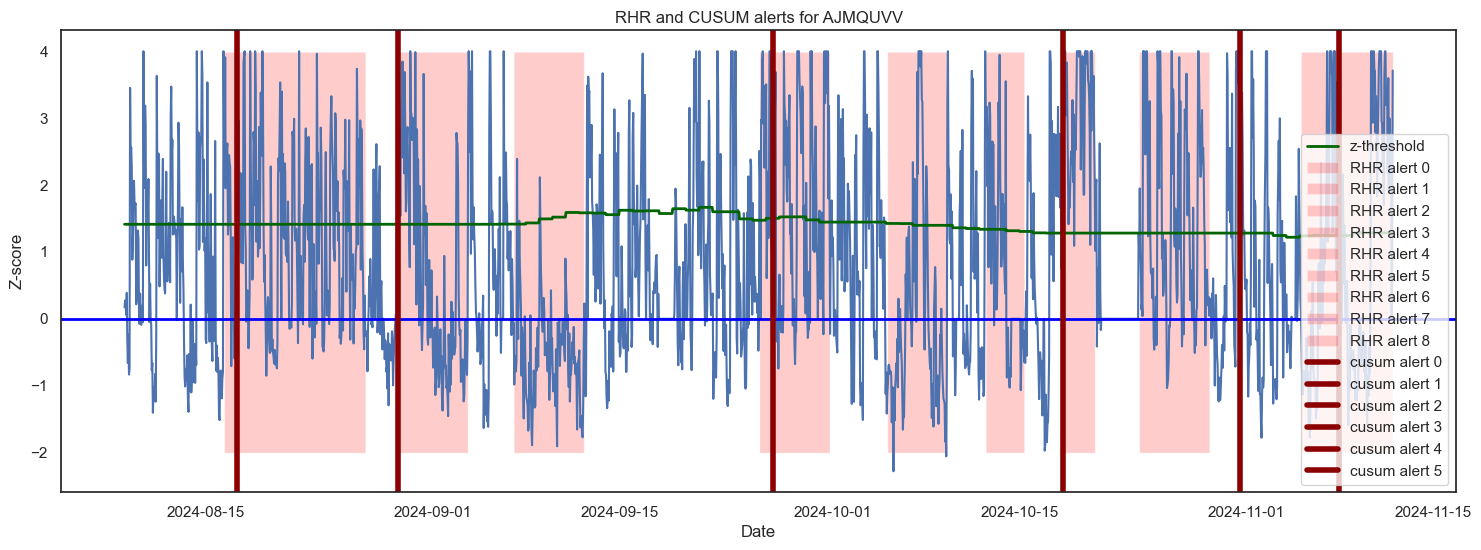

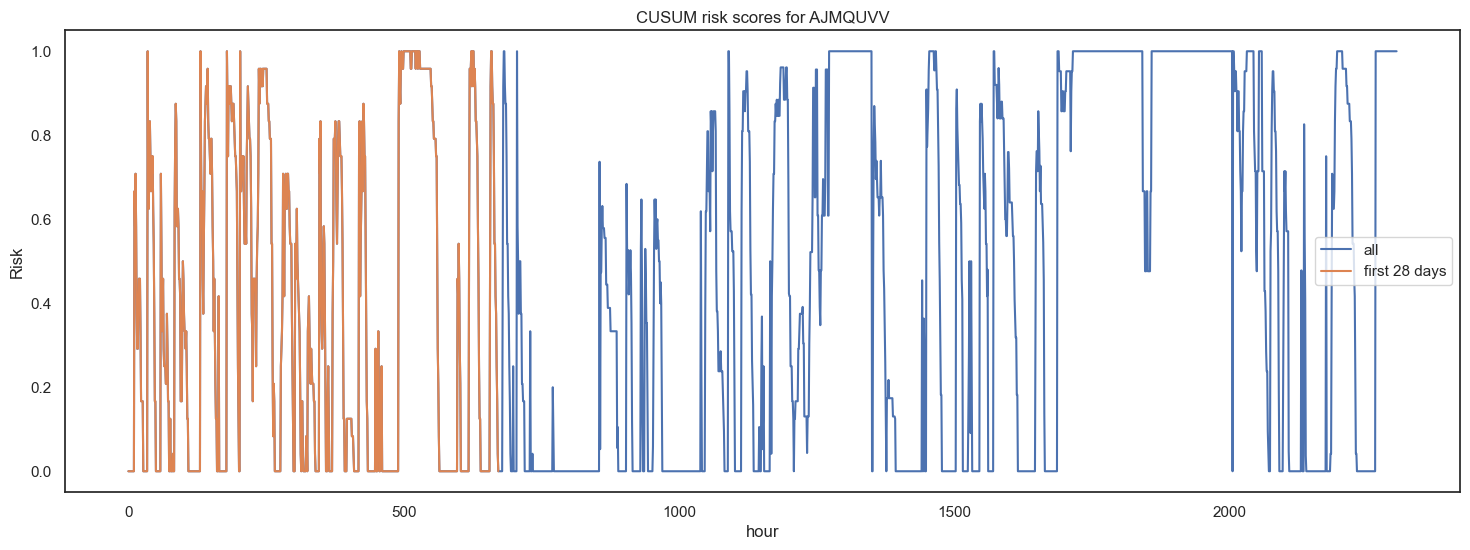

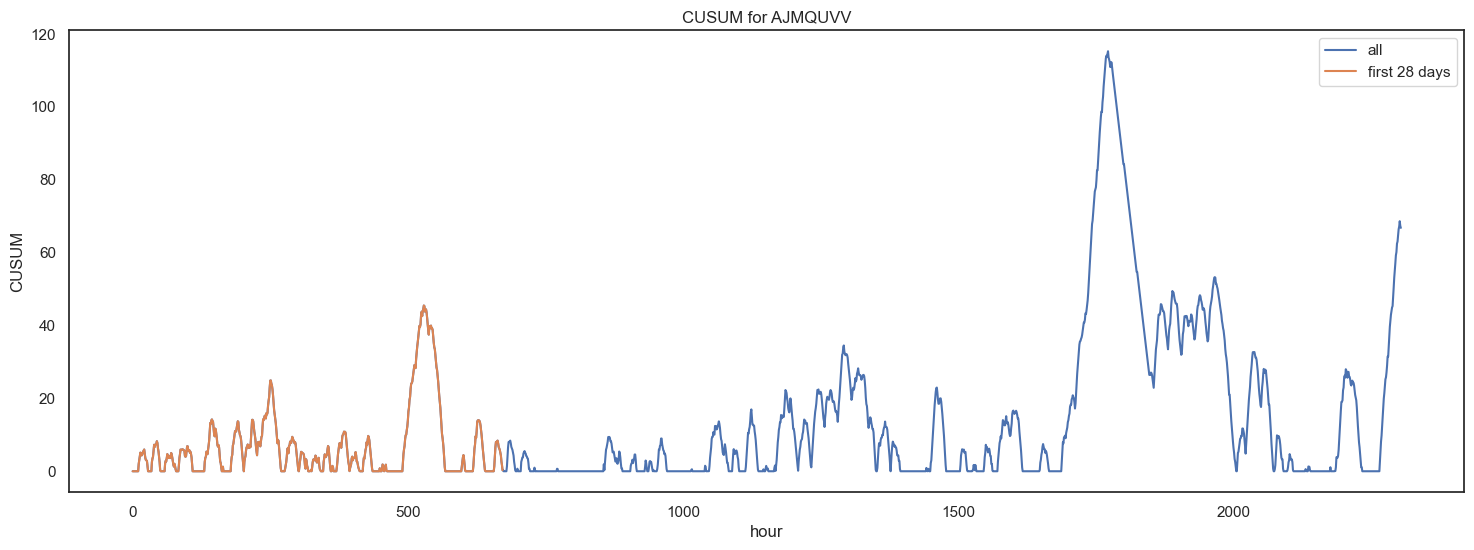

In [32]:
patient_name ='AJMQUVV'


ar_cusum,ar_cusum_baseline,ar_cusum_idx,z_vals,z_cutoffs,risk_scores,risk_scores_baseline=getRHRandCUSUMdata(patient_name, robust=False)
alpha=0.01
seed=3453674
cusums = getCusumAlerts(ar_cusum, ar_cusum_idx, risk_scores, z_vals)
rhrs = getRHRalerts(z_vals, alpha=alpha, seed=seed)

fig = plotAlerts(patient_name, l_cusums=cusums, df_rhrs=rhrs, ar_zvals=z_vals, ar_cutoff=z_cutoffs, save=False)
fig1 = plotCusumRisks(patient_name, ar_risks=risk_scores, ar_risks_baseline=risk_scores_baseline, save=False)
fig2 = plotCusumProfile(patient_name, ar_cusums=ar_cusum, ar_cusums_baseline=ar_cusum_baseline, save=False)


### calculate all

In [35]:
mypath='/Users/zagidull/Documents/gerosense/presymptomatic_covid_detection_algo/data_covidwearables/'

onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
onlynames = list(set([f.split('_')[0] for f in onlyfiles]))
print(onlynames)

['AFHOHOM', 'A8QLAB0', 'AEOHH30', 'A0KX894', 'AKTGD8X', 'AEZDKVO', 'AUILKHG', 'AQ25Y0L', 'AK7YRBU', 'AMQUHOQ', 'AL48GP3', 'AZ35PI5', 'AYEFCWQ', 'AOYM4KG', 'A11SQQN', 'A0L9BM2', 'AZIK4ZA', 'AXCO7I9', 'AXDWDEA', 'AUY8KYW', 'AXD3W8O', 'A5XL2IC', 'AQR8ZSS', 'AQC0L71', 'AGKI03N', 'AFVAEC7', 'A3OU183', 'AZKZ0AI', 'A35BJNV', 'AOGFRXL', 'A91HEZV', 'AF3MXM1', 'A65HVGP', 'ATHKM6V', 'AKV66US', 'A2P3LTM', 'A2D7K4A', 'AWA2KJK', 'AO20DS4', 'AKXN5ZZ', 'AIFDJZB', 'ARFYLMK', 'AJ0DKQ3', 'AYWIEKR', 'AA0HAI1', 'AZ2RYW7', 'AHYIJDV', 'AAF9ACE', 'AWRBUQZ', 'AOS4BSJ', 'ATHBFWX', 'AOQA85X', 'AFEFA29', 'A4G0044', 'A0N9NV4', 'A06L7KF', 'AMV7EQF', 'AD77K91', 'AE2B3RH', 'AJMQUVV', 'AGYQJEL', 'AUCGUF3', 'AOB9SON', 'A1ZJ41O', 'A8CBEJZ', 'A4H7SNF', 'AF3J1YC', 'A2XFW2N', 'A4E0D03', 'ASFODQR', 'A45F9E6', 'A7EAWA7', 'AF8R0I6', 'AXI1PBS', 'A36HR6Y', 'AYVQUF1', 'AAXAA7Z', 'AL3KT5B', 'A3ADWUT', 'A0NVTRV', 'AV2GF3B', 'A9ZG5GR', 'ATT9RR1', 'A99ZKKW', 'AGA8XUN', 'APHNRSV', 'A0822M0', 'AY8TPMP', 'AA2KP1S', 'AFYLHG4', 'AFPB8J2'

In [30]:
error_names = []
for patient_name in onlynames:
    try:
        ar_cusum,ar_cusum_baseline,ar_cusum_idx,z_vals,z_cutoffs,risk_scores,risk_scores_baseline=getRHRandCUSUMdata(patient_name)
        alpha=0.01
        seed=345346
        cusums = getCusumAlerts(ar_cusum, ar_cusum_idx, risk_scores, z_vals)
        rhrs = getRHRalerts(z_vals, alpha=alpha, seed=seed)
        mypath = f'/Users/zagidull/Documents/gerosense/presymptomatic_covid_detection_algo/figs/{patient_name}'
        if not os.path.isdir(mypath):
            os.makedirs(mypath)
            plotRHR(patient_name, save=True, path=mypath)
            plotAlerts(patient_name, l_cusums=cusums, df_rhrs=rhrs, ar_zvals=z_vals, ar_cutoff=z_cutoffs, save=True, path=mypath)
            plotCusumRisks(patient_name, ar_risks=risk_scores, ar_risks_baseline=risk_scores_baseline, save=True, path=mypath)
            plotCusumProfile(patient_name, ar_cusums=ar_cusum, ar_cusums_baseline=ar_cusum_baseline, save=True, path=mypath)
    except:
        error_names.append(patient_name)
        print(patient_name)
        continue

/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/4272567239.py:15: RuntimeWarning: invalid value encountered in divide
  lambda x: (x.values-df_refRHR.loc[x.index.hour,'RHR_mean'].values)/df_refRHR.loc[x.index.hour,'RHR_std'].values
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_acce

AFHOHOM
AK7YRBU


/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/220

A35BJNV
A2XFW2N


/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/4272567239.py:15: RuntimeWarning: invalid value encountered in divide
  lambda x: (x.values-df_refRHR.loc[x.index.hour,'RHR_mean'].values)/df_refRHR.loc[x.index.hour,'RHR_std'].values
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_acce

A99ZKKW
AGKI03N


/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/220

AA0HAI1


/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/220

ATHKM6V


/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/4272567239.py:15: RuntimeWarning: divide by zero encountered in divide
  lambda x: (x.values-df_refRHR.loc[x.index.hour,'RHR_mean'].values)/df_refRHR.loc[x.index.hour,'RHR_std'].values
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_acc

A3ADWUT
A0N9NV4
AZ35PI5


/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


AHYR55C


/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/220

AD77K91


In [487]:
error_names_upd = []
for patient_name in error_names:
    try:
        ar_cusum,ar_cusum_baseline,ar_cusum_idx,z_vals,z_cutoffs,risk_scores,risk_scores_baseline=getRHRandCUSUMdata(patient_name)
        alpha=0.01
        seed=345346
        cusums = getCusumAlerts(ar_cusum, ar_cusum_idx, risk_scores, z_vals)
        rhrs = getRHRalerts(z_vals, alpha=alpha, seed=seed)
        mypath = f'/Users/zagidull/Documents/gerosense/presymptomatic_covid_detection_algo/figs/{patient_name}'
        if not os.path.isdir(mypath):
            os.makedirs(mypath)
            plotRHR(patient_name, save=True, path=mypath)
            plotAlerts(patient_name, l_cusums=cusums, df_rhrs=rhrs, ar_zvals=z_vals, ar_cutoff=z_cutoffs, save=True, path=mypath)
            plotCusumRisks(patient_name, ar_risks=risk_scores, ar_risks_baseline=risk_scores_baseline, save=True, path=mypath)
            plotCusumProfile(patient_name, ar_cusums=ar_cusum, ar_cusums_baseline=ar_cusum_baseline, save=True, path=mypath)
    except:
        error_names_upd.append(patient_name)
        continue

/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_accelerate/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/4112931716.py:15: RuntimeWarning: invalid value encountered in divide
  lambda x: (x.values-df_refRHR.loc[x.index.hour,'RHR_mean'].values)/df_refRHR.loc[x.index.hour,'RHR_std'].values
/var/folders/dp/xxb4c2vd43j5qd499z0k99_spvqncj/T/ipykernel_52037/2207976457.py:5: RuntimeWarning: Mean of empty slice
  df['RHR_mean'] = grouper.transform(lambda x: np.nanmean(x)) # mind pandas native .mean/.std implementation and NaN handling
/Users/zagidull/miniconda3/envs/blas_acce

In [690]:
patient_name='A2XFW2N'

ar_cusum,ar_cusum_baseline,ar_cusum_idx,z_vals,z_cutoffs,risk_scores,risk_scores_baseline=getRHRandCUSUMdata(patient_name)
alpha=0.01
seed=345346
cusums = getCusumAlerts(ar_cusum, ar_cusum_idx, risk_scores, z_vals)
rhrs = getRHRalerts(z_vals, alpha=alpha, seed=seed)

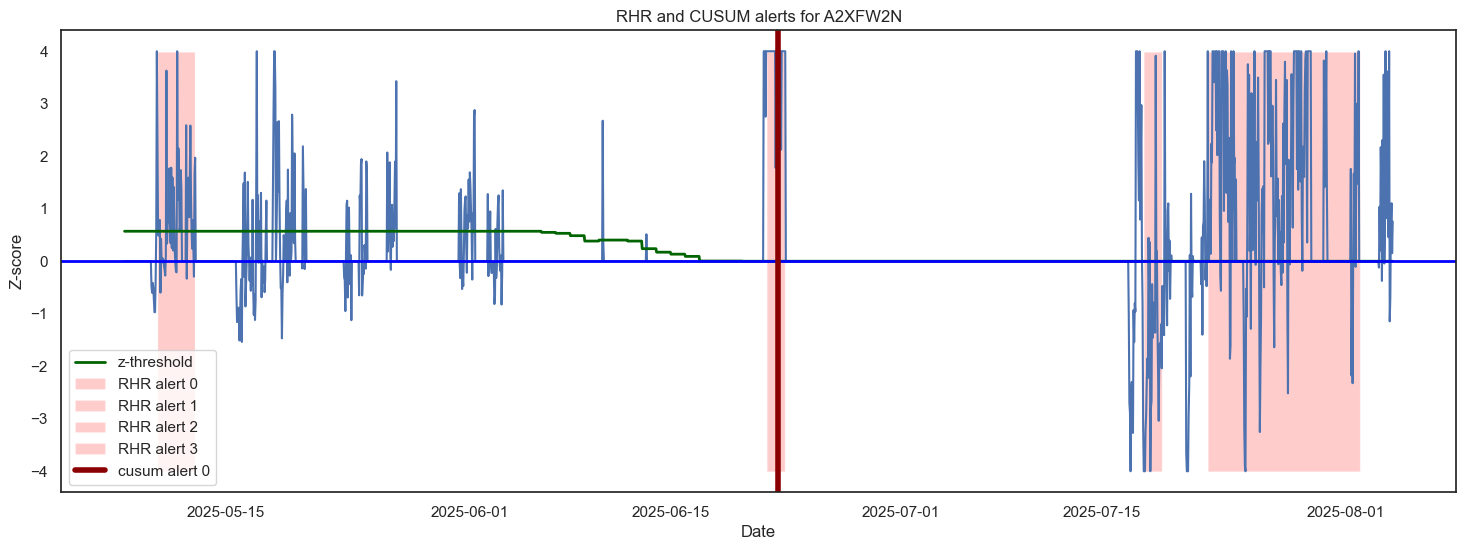

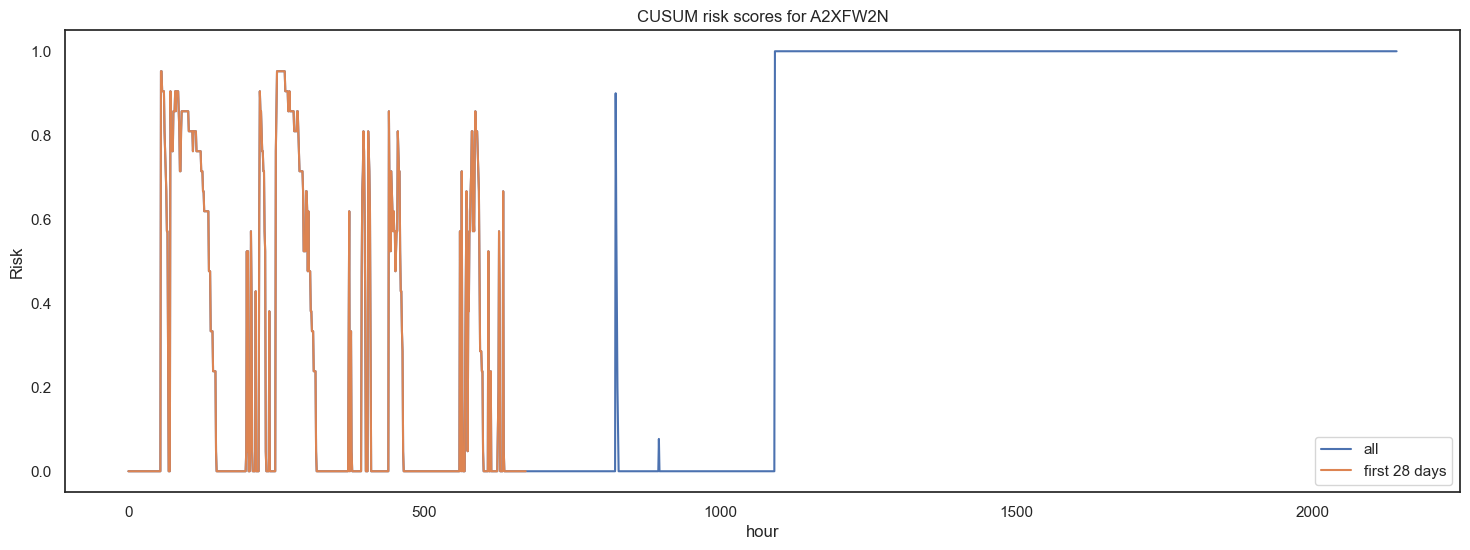

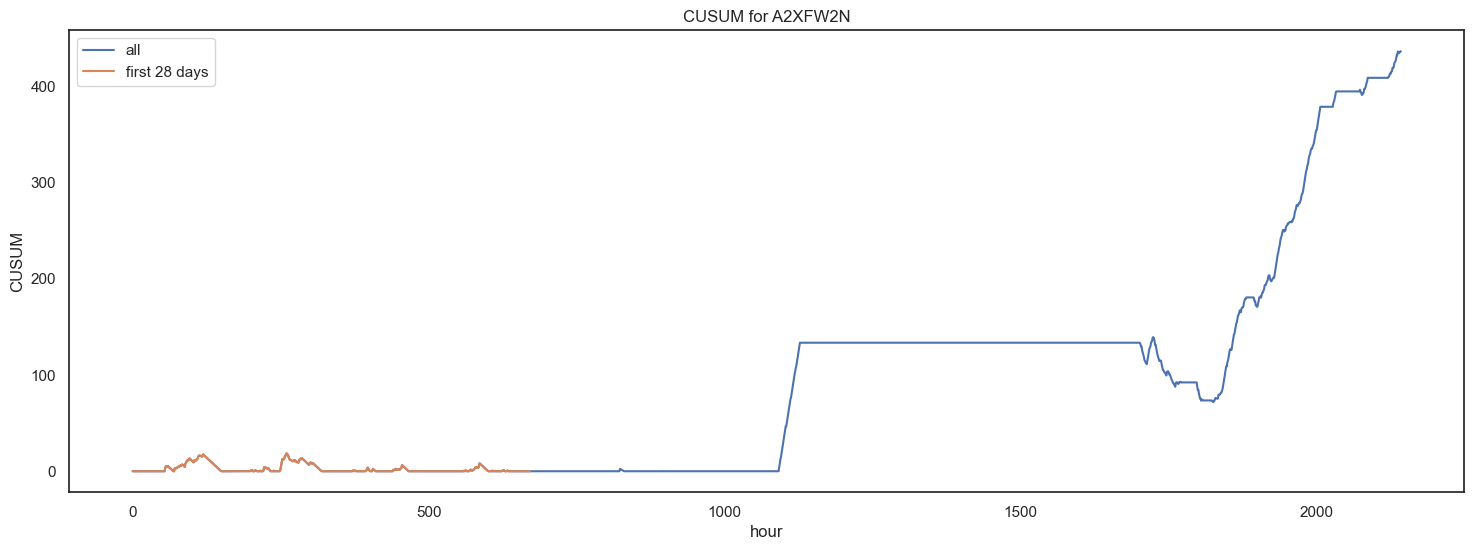

In [691]:

# plotRHR(patient_name, save=False)
fig_alerts = plotAlerts(patient_name, l_cusums=cusums, df_rhrs=rhrs, ar_zvals=z_vals, ar_cutoff=z_cutoffs, save=False)
fig_risks = plotCusumRisks(patient_name, ar_risks=risk_scores, ar_risks_baseline=risk_scores_baseline, save=False)
fig_cusums = plotCusumProfile(patient_name, ar_cusums=ar_cusum, ar_cusums_baseline=ar_cusum_baseline, save=False)

In [477]:
def getRHRandCUSUMdata_alt(patient_name: str, pval=0.01):
    ##########
    #BASELINE get reference dataset from the first 28 days of measurements
    ##########
    
    df = readDF(patient_name)
    df_ref = prepBaseline(df) 
    #df_ref.dropna(inplace=True) # how to better deal with NAs? for now i manage them when calculating z-scores/residuals by filling with zero
    df_ref = smoothRolling(df_ref)
    df_RHR = getRHR(df_ref) # get RHR based on reference from first 28 days

    df_hourly = getZscore(df_ref, df_RHR) # calculate z-scoresfor anomaly detection 
    zthreshold = getResidualThreshold(df_hourly.zscore) # use ref data to get z-threshold , after downsampling to hourly (from minutes
    
    # to store results for later plotting and alerts
    z_cutoffs = pd.Series(data=np.nan, index=df.resample('60T').median().index)
    z_vals = pd.Series(data=np.nan, index=df.resample('60T').median().index)
    z_vals.loc[df_hourly.index]=df_hourly.zscore
    z_cutoffs.loc[df_hourly.index]=zthreshold

    ar_cusumREF = getCusumBase(df_hourly['zscore'].values, zthreshold) # calculate CUSUM statistic for reference
    d_ecdf=getECDF_alt(ar_cusumREF) # get ECDFs for CUSUM
    ar_cusumREF_idx = getCusumIdx(ar_cusumREF) # get idx of positive cusum values, indexing restarts once a cusum zero value is reached 
    
    # risk scores for reference
    risk_scores = getRiskScores(ar_cusumREF, ar_cusumREF_idx, d_ecdf)

    ##########
    #TESTDATA#
    ##########
    pval = pval
    risk_threshold = 1-pval # when to update reference   
    
    ar_cusum = ar_cusumREF.copy()
    ar_cusum_baseline = ar_cusumREF.copy()
    ar_cusum_idx = ar_cusumREF_idx.copy()
    ar_cusum_idx_baseline = ar_cusumREF_idx.copy()
    risk_scores_baseline = risk_scores.copy()

    dates = list(df.groupby(df.index.date).groups.keys())
    for date in dates[28:]:
        
        df_test = prepTest(df, date)
        df_test_hourly = getZscore(df_test, df_RHR)
        # df_test_hourly['zthreshold'] = getResidualThreshold(df_test_hourly.zscore) #  not needed when only test data
        z_vals.loc[df_test_hourly.index]=df_test_hourly.zscore.values
    
        # get cusum scores with new data
        ar_cusum_test = getCusumTest(df_test_hourly.zscore, ar_cusum, zthreshold)
        ar_cusum = np.concatenate((ar_cusum, ar_cusum_test))
        
        # get cusum idx with new data
        ar_cusum_test_idx = updateCusumIdx(ar_cusum_test, ar_cusum_idx)
        ar_cusum_idx = np.concatenate((ar_cusum_idx, ar_cusum_test_idx))
    
        # get risk scores with new data
        risk_scores_test = getRiskScores(ar_cusum_test, ar_cusum_test_idx, d_ecdf)
        risk_scores = np.concatenate((risk_scores, risk_scores_test))
    
        if not np.any(risk_scores_test > risk_threshold):
            # update baseline
            old_ref = np.unique(pd.concat([df_hourly, df_test_hourly]).index.date).tolist()
            new_ref = old_ref[1:]
            
            df_ref = df.loc[np.isin(df.index.date, new_ref)]
            df_ref = smoothRolling(df_ref)
            df_RHR = getRHR(df_ref) 
            
            df_hourly = getZscore(df_ref, df_RHR) 
            if np.unique(df_hourly.index.date).shape[0] != 28: # resampling in getZscore creates NaN for missing days, this corrects it
                df_hourly = df_hourly.loc[np.isin(df_hourly.index.date, df_ref.index.date)]

            # new z-threshold 
            zthreshold = getResidualThreshold(df_hourly.zscore)
            start=z_cutoffs[z_cutoffs.isna()].index[0]
            end=df_hourly.index[-1]
            z_cutoffs.loc[start:end]=zthreshold

            # new CUSUM threshold and ECDF
            ar_cusumREF = getCusumBase(df_hourly['zscore'].values, zthreshold)
            d_ecdf=getECDF_alt(ar_cusumREF)
    z_cutoffs.ffill(inplace=True)
    
    return ar_cusum,ar_cusum_baseline,ar_cusum_idx,z_vals,z_cutoffs,risk_scores,risk_scores_baseline

In [671]:
ar_cusum,ar_cusum_baseline,ar_cusum_idx,z_vals,z_cutoffs,risk_scores,risk_scores_baseline=getRHRandCUSUMdata_alt(patient_name)
alpha=0.001
seed=345346
cusums = getCusumAlerts(ar_cusum, ar_cusum_idx, risk_scores, z_vals)
rhrs = getRHRalerts(z_vals, alpha=alpha, seed=seed)


In [672]:
cusums

[Timestamp('2027-01-17 01:00:00'),
 Timestamp('2027-03-03 10:00:00'),
 Timestamp('2027-03-08 05:00:00'),
 Timestamp('2027-03-26 06:00:00')]

In [673]:
rhrs

,begin detect period,end detect period
0,2026-12-30 22:00:00,2027-01-01 04:00:00
1,2027-01-17 08:00:00,2027-02-15 04:00:00
2,2027-03-04 10:00:00,2027-03-05 16:00:00
3,2027-03-08 08:00:00,2027-03-13 14:00:00
4,2027-03-23 23:00:00,2027-03-25 05:00:00


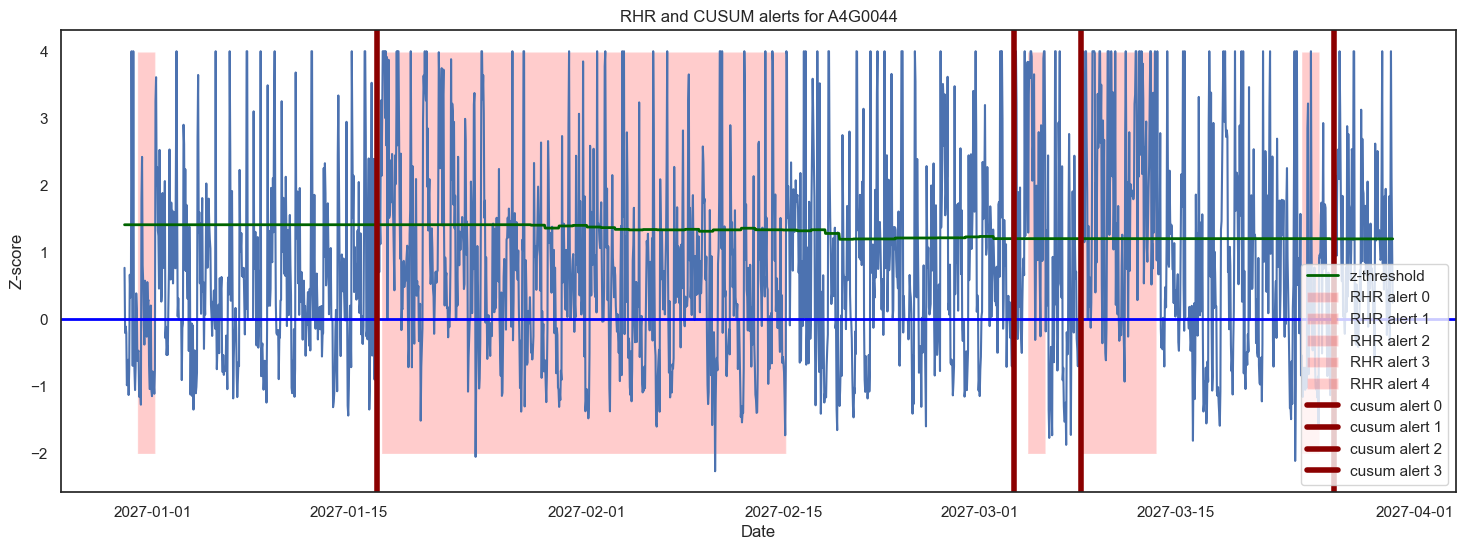

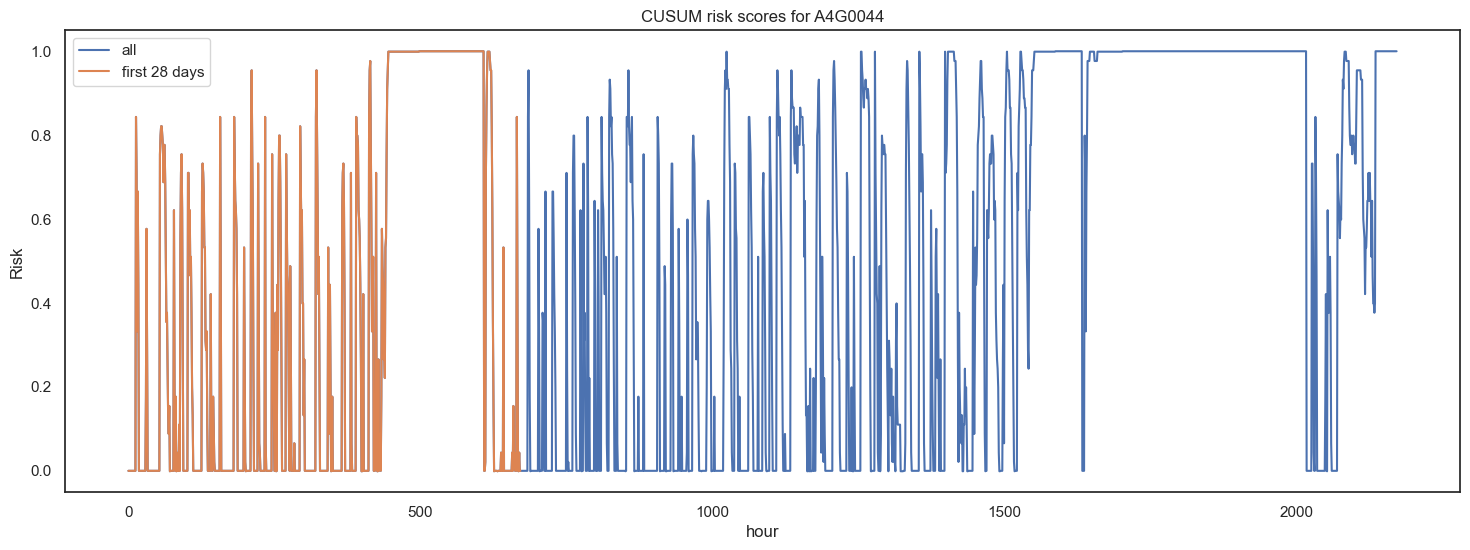

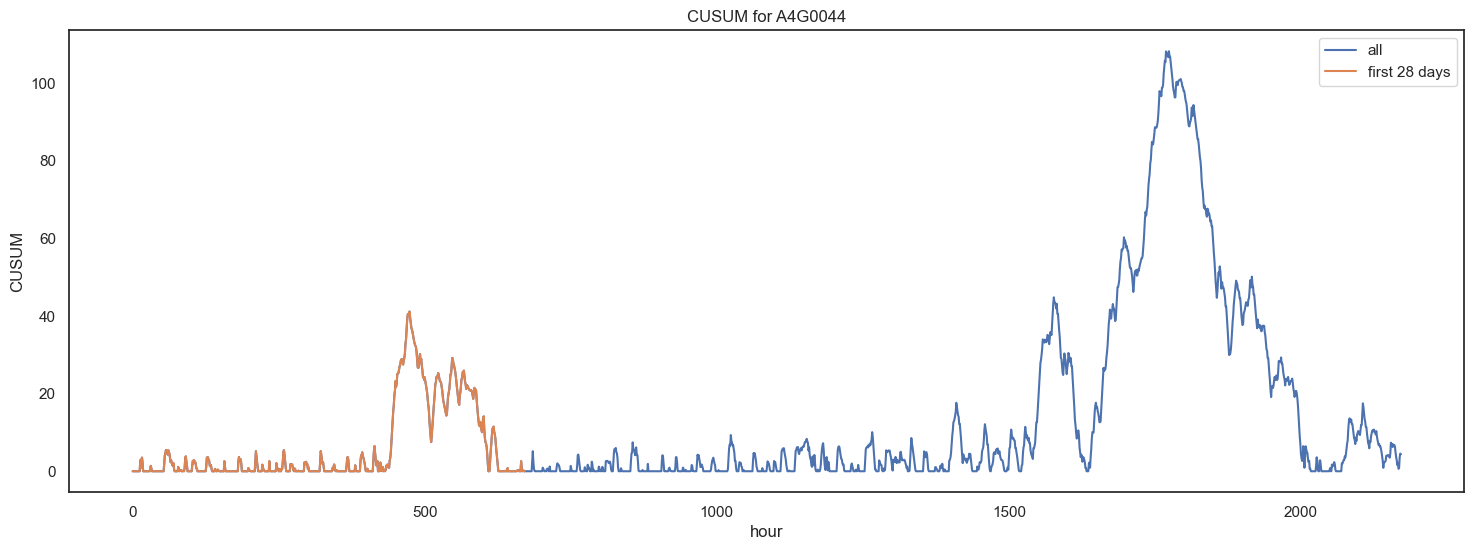

In [674]:

# plotRHR(patient_name, save=False)
fig_alerts = plotAlerts(patient_name, l_cusums=cusums, df_rhrs=rhrs, ar_zvals=z_vals, ar_cutoff=z_cutoffs, save=False)
fig_risks = plotCusumRisks(patient_name, ar_risks=risk_scores, ar_risks_baseline=risk_scores_baseline, save=False)
fig_cusums = plotCusumProfile(patient_name, ar_cusums=ar_cusum, ar_cusums_baseline=ar_cusum_baseline, save=False)